Direct damages calculation for CI Adapt

In [ ]:
# Imports
from direct_damages import damagescanner_rail_track as ds
from ci_adapt_utilities import *

Load default configuration and model parameters

In [ ]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt_test.ini'
hazard_type, infra_type, _, country_name, _, _, vulnerability_data = load_config(config_file)

In [ ]:
# Define paths
data_path = Path(pathlib.Path(r'C:\Users\peregrin\OneDrive - Stichting Deltares\Documents\PhD Daniel Shared\Papers\Paper 1 - Adaptation Framework\Data\test'))
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

In [30]:
# Load asset data (OSM, 2024)
assets, geom_dict, _, _, _, rp_spec_priority, _, _, _ = startup_ci_adapt(data_path, config_file)
asset_options={'bridge_design_rp':'M',
               'tunnel_design_rp':'M'}

675 assets loaded.


In [31]:
# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
type_dict = assets['asset'].to_dict()

In [32]:
# Read vulnerability and maximum damage data from Nirandjan, S., et al. (2024)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.1.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

Found matching infrastructure curves for: rail


In [33]:
# Read hazard data (Rauthe M, et al. (2020): Climate impact analysis of the federal transport system in the context of floods: Final report of the key topic flood risks (SP-103) in topic area 1 of the BMVI expert network. 136 pages. DOI: 10.5675/ExpNRM2020.2020.04)
# n_drive_dpath=Path(r'N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps')
test_haz_path = data_path / r'Floods\Germany\basin_intersections'
hazard_data_list = ds.read_hazard_data(test_haz_path, hazard_type, country=country_name, subfolders=None)
print(f'Found {len(hazard_data_list)} hazard maps.')

Found 3 hazard maps.


Overlay hazard and asset data

In [34]:
# Calculate direct damage by asset (Koks. E.E. (2022). DamageScanner: Python tool for natural hazard damage assessments. Zenodo. http://doi.org/10.5281/zenodo.2551015)
collect_output={}
for i, single_footprint in enumerate(hazard_data_list):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Reading hazard map {i+1} of {len(hazard_data_list)}: {hazard_name}')

    try:
        collect_output[hazard_name] = process_hazard_data(single_footprint, hazard_type, assets, interim_data_path, infra_curves, max_damage_tables, curve_types, infra_type, type_dict, geom_dict, asset_options=asset_options, rp_spec_priority=rp_spec_priority)
    except Exception as e:
        print(f'Error occurred in {hazard_name}: {str(e)}')
        continue

# save the data to pickle files
collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
if len(collect_output)>0:
    with open(collect_output_path, 'wb') as f:
        pickle.dump(collect_output, f)
else: print('No output collected')

2024-12-02 16:55:48 - Reading hazard map 1 of 3: flood_DERP_RW_H_4326_2080430320
2024-12-02 16:55:50 - Coarse overlay of hazard map with assets...


  0%|          | 0/20 [00:00<?, ?it/s]

2024-12-02 16:56:28 - Reading hazard map 2 of 3: flood_DERP_RW_L_4326_2080430320
2024-12-02 16:56:32 - Coarse overlay of hazard map with assets...


  0%|          | 0/42 [00:00<?, ?it/s]

2024-12-02 16:58:34 - Reading hazard map 3 of 3: flood_DERP_RW_M_4326_2080430320
2024-12-02 16:58:37 - Coarse overlay of hazard map with assets...


  0%|          | 0/33 [00:00<?, ?it/s]

Save overlay data to files for reuse in later stages

In [35]:
# Save the data to csv files
csv_output_path=f'collected_run_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
pd.DataFrame.from_dict(collect_output).to_csv(interim_data_path / csv_output_path)

In [36]:
# if collected_output variable doesnt exist, load from pickle file
if 'collect_output' not in locals():
    collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

Visualise direct damages and calculate risk

In [37]:
# Calculate the expected annual damages (EAD)
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

# Initialize a new dictionary to hold the aggregated values
aggregated_output = {'_H_': [0, 0], '_M_': [0, 0], '_L_': [0, 0]}

# Iterate over the items in the summed_output dictionary and group into return periods
for hazard_map, (lower_bound, upper_bound) in summed_output.items():
    # determine the category of the hazard map
    if '_H_' in hazard_map: 
        category = '_H_'
    elif '_M_' in hazard_map: 
        category = '_M_'
    else: # '_L_' in hazard_map
        category = '_L_' 
        
    # Add the lower and upper bounds to the appropriate category
    aggregated_output[category][0] += lower_bound
    aggregated_output[category][1] += upper_bound

# Create the DataFrame from the new dictionary
aggregated_df = pd.DataFrame.from_dict(aggregated_output, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
aggregated_df


,Total Damage Lower Bound,Total Damage Upper Bound
_H_,"223,292.121","274,375.742"
_M_,"278,408.496","1,047,373.820"
_L_,"9,355,306.384","20,914,827.971"


Baseline expected annual damages: 110,184.26 to 239,536.56 EUR
Expected annual damages without adaptation by year 100: 380,957.82 to 864,574.07 EUR


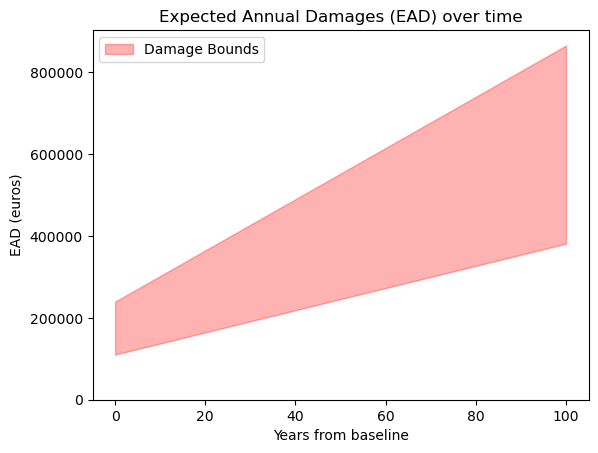

In [ ]:
# Calculating risk for a single basin
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. This value is catchment-specific. 
increase_factor = {
    '_H_': 2,
    '_M_': 4.21,
    '_L_': 5.86
} # Mentaschi et al. (2016)

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

# Define dictionary to relate return periods to regions, in this case Rheinland Palatinate is used
return_period_dict = {}
return_period_dict['DERP'] = return_periods #TODO: make generic for other regions

# Add the return period column to aggregated_df and sort by return period
aggregated_df['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df.index]
aggregated_df = aggregated_df.sort_values('Return Period', ascending=True)

# Calculate the probability of each return period 
aggregated_df['Probability'] = [[1 / x for x in i] for i in aggregated_df['Return Period']]
probabilities = aggregated_df['Probability']
dmgs = []

# Calculate the expected annual damages for each time step using trapezoidal rule for integration
for ts in range(len(probabilities.iloc[0])):    
    dmgs_l = []
    dmgs_u = []

    for rp in range(len(probabilities)-1):
        d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
        trap_damage_l = 0.5 * (aggregated_df['Total Damage Lower Bound'].iloc[rp] + aggregated_df['Total Damage Lower Bound'].iloc[rp + 1])
        trap_damage_u = 0.5 * (aggregated_df['Total Damage Upper Bound'].iloc[rp] + aggregated_df['Total Damage Upper Bound'].iloc[rp + 1])
        dmgs_l.append(d_rp * trap_damage_l)
        dmgs_u.append(d_rp * trap_damage_u)
    
    # Add the portion of damages corresponding to the tails of the distribution
    # Assumption - considers the damage for return periods higher than the highest return period the same as that of the highest return period
    d0_rp = probabilities.iloc[-1][ts]
    damage_l0 = max(aggregated_df['Total Damage Lower Bound'])
    damage_u0 = max(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d0_rp * damage_l0)
    dmgs_u.append(d0_rp * damage_u0)

    # Assumption - considers that no assets are damaged at a return period of 4 years or lower
    d_end_rp = (1/4)-probabilities.iloc[0][ts]
    damage_l_end = 0.5 * min(aggregated_df['Total Damage Lower Bound'])
    damage_u_end = 0.5 * min(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d_end_rp * damage_l_end)
    dmgs_u.append(d_end_rp * damage_u_end)

    dmgs.append((sum(dmgs_l), sum(dmgs_u)))

ead_by_ts = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

print(f'Baseline expected annual damages: {dmgs[0][0]:,.2f} to {dmgs[0][1]:,.2f} EUR')
print(f'Expected annual damages without adaptation by year {num_years}: {dmgs[-1][0]:,.2f} to {dmgs[-1][1]:,.2f} EUR')

ead_by_ts_plot(ead_by_ts)

In [39]:
# Sum the direct damages for each hazard map
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

summed_output

{'flood_DERP_RW_H_4326_2080430320': (223292.12147988414, 274375.7418432404),
 'flood_DERP_RW_L_4326_2080430320': (9355306.384249477, 20914827.97101291),
 'flood_DERP_RW_M_4326_2080430320': (278408.4957824896, 1047373.8201867895)}

In [ ]:
# Calculate the expected annual damages (EAD) by basin for multiple basins
files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in summed_output.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = summed_output[key]

aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

In [41]:
total_damage_lower_bound = ead_by_ts_by_basin[basins_list[0]]['Total Damage Lower Bound']
total_damage_upper_bound = ead_by_ts_by_basin[basins_list[0]]['Total Damage Upper Bound']
print(f'Baseline expected annual damages for basin {basins_list[0]}:{sum(total_damage_lower_bound):,.2f} to {sum(total_damage_upper_bound):,.2f} EUR over {num_years} years')

Baseline expected annual damages for basin 2080430320:24,802,674.79 to 55,757,586.70 EUR over 100 years


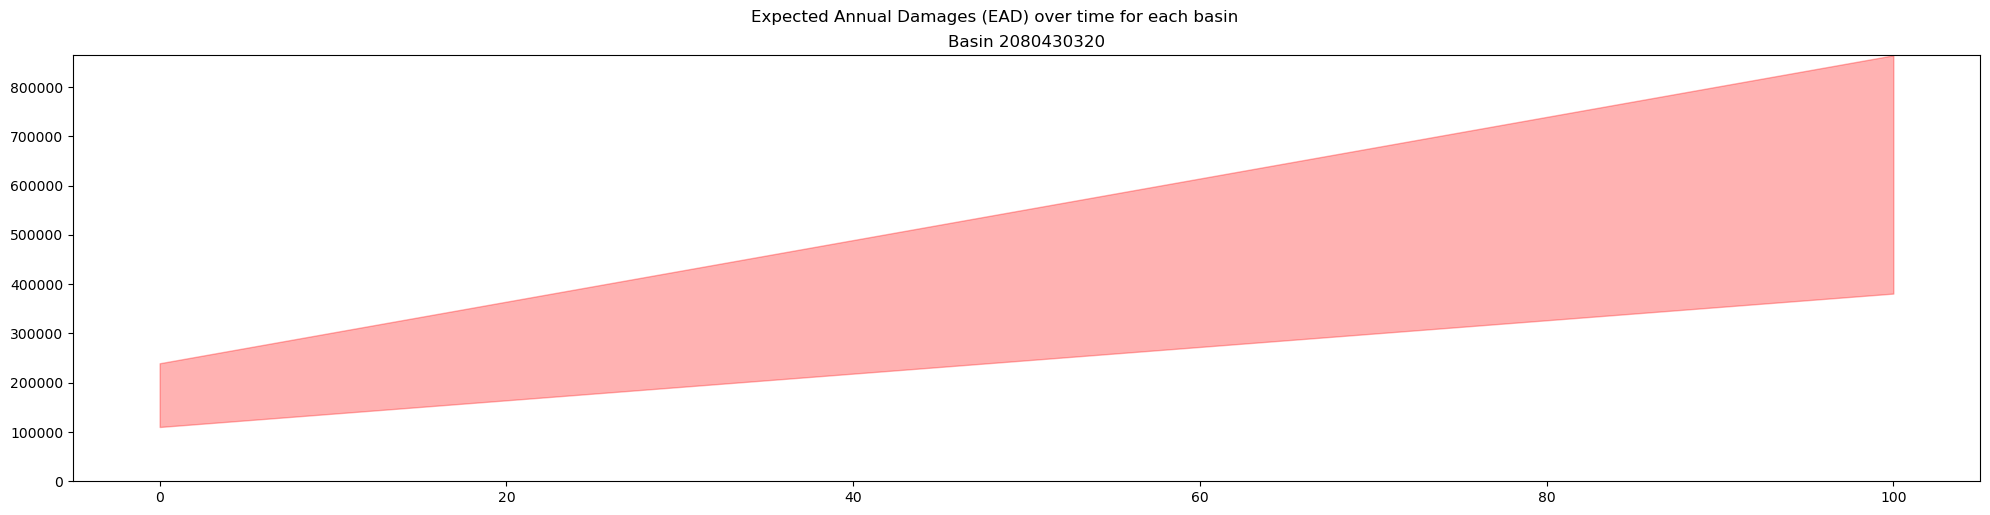

In [42]:
# Calculate the number of rows and columns based on the number of basins
num_basins = len(ead_by_ts_by_basin)
num_cols = int(np.ceil(np.sqrt(num_basins)))
num_rows = int(np.ceil(num_basins / num_cols))

# Create subplots with shared x-axis, the calculated number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows), sharex=True, sharey=True)

# Flatten axs array for easy iteration
try:
    axs = axs.flatten()
except:
    axs = [axs]

max_value = max([ead_by_ts_by_basin[basin]['Total Damage Upper Bound'].max() for basin in ead_by_ts_by_basin.keys()])

for i, basin in enumerate(ead_by_ts_by_basin.keys()):
    axs[i].fill_between(ead_by_ts_by_basin[basin].index, ead_by_ts_by_basin[basin]['Total Damage Lower Bound'], ead_by_ts_by_basin[basin]['Total Damage Upper Bound'], alpha=0.3, color='red')
    axs[i].set_title(f'Basin {basin}')
    axs[i].set_ylim(0, max_value)  # Set y-axis lower limit to 0 and upper limit to max_value

# Hide any unused axes
for j in range(num_basins, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.suptitle('Expected Annual Damages (EAD) over time for each basin', y=1.02)
plt.show()


In [43]:
with open(f'{interim_data_path}/ead_by_ts_by_basin_direct.pkl', 'wb') as f:
    pickle.dump(ead_by_ts_by_basin, f)

In [44]:
ead_by_ts_by_basin

{2080430320:      Total Damage Lower Bound  Total Damage Upper Bound
 0                 110,184.256               239,536.555
 1                 112,891.992               245,786.930
 2                 115,599.727               252,037.306
 3                 118,307.463               258,287.681
 4                 121,015.199               264,538.056
 ..                        ...                       ...
 96                370,126.877               839,572.572
 97                372,834.612               845,822.947
 98                375,542.348               852,073.322
 99                378,250.083               858,323.697
 100               380,957.819               864,574.072
 
 [101 rows x 2 columns]}